# Time Series Defect Detection and Root Cause Analysis with use of RNN

**Authors:**
* Jakub Radziejewski
* Jakub Jęsiek 

---

##  Problem Statement

This report details the development of a Recurrent Neural Network (RNN) based system designed for a candy manufacturing client. The production line is monitored by **three sensors**, generating time-series data. The manufacturing process is plagued by **five specific types of defects**.

### Goals
* **Multi-label Classification:** Predict which defects (if any) are present in a given sample.
* **Root Cause Analysis (Explainability):** Localize the specific time intervals and sensors responsible for the detected defects.




### Constraints & Challenges
* **Variable sequence lengths:** ($T \in [40, 60]$).
* **Multiple defects** can occur simultaneously.
* **Generalizability:** The solution must be data-agnostic (generalizable beyond the current synthetic sine-wave dataset).
* **Signal Dynamics:** One defect ("Zero S2") is characterized by a flatline, which requires analyzing signal dynamics (velocity) rather than just magnitude.

# Main Approach (Bi-directional LSTM with Per-Class Attention)

## 1. Methodology and Architecture

We have selected a **Bi-directional LSTM with Per-Class Attention**.

* **Bi-directional LSTM:** Allows the model to see both past and future context for every time step, which is crucial for identifying patterns like "drops" or "bumps."
* **Per-Class Attention:** This is the critical innovation in this solution. Unlike standard models that predict all classes from one vector, this architecture maintains a separate attention mechanism for each defect type. Note: Defect type properties are not encoded in any way, we only know the number of possible defects, not their properties

**Impact:** This means the model can focus on time step $t=10$ to find Defect A, while simultaneously focusing on time step $t=50$ to find Defect B. This perfectly handles the multi-label requirement.

## 2. Data Generation

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# Seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def createRow(n, classes):
    # Base signal: Sine waves with noise
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    
    # Class 0: Spike on Sensor 0
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    # Class 1: Drop on Sensor 1
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    # Class 2: Dead Sensor 2 (Zeroing)
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    # Class 3: Bump on Sensor 1
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    # Class 4: Simultaneous Pattern (Sensor 0 & 2)
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
        
    base += np.random.rand(*base.shape)*.2
    return base

# Generate Data
N_SAMPLES = 200000
X_list, y_list = [], []

print("Generating dataset...")
for _ in range(N_SAMPLES):
    cl = np.random.rand(5) < 0.25 
    seq_len = np.random.randint(40, 60)
    X_list.append(createRow(seq_len, cl))
    y_list.append(cl.astype(float))

print(f"Dataset generated: {len(X_list)} samples.")

Using device: cuda
Generating dataset...
Dataset generated: 200000 samples.


## 3. Model Implementation

The following code is the core architecture. It uses a custom **AttentionLSTM**. The design includes `self.attention_layers` as a `ModuleList`, creating a specific attention mechanism for every single defect class.

**Why this design?**
This is far superior to a shared attention layer because different defects have different temporal characteristics:
* **"Spike":** Characterized by short, sudden bursts.
* **"Bump":** Characterized by longer, gradual shifts.

By using a **ModuleList** of attention layers, the model learns to "look" for different temporal signatures independently for each label.


In [46]:
NUM_SENSORS = 3           # Number of sensors
NUM_DEFECT_TYPES = 5      # Number of defect types
HIDDEN_SIZE = 128
BATCH_SIZE = 32
NUM_EPOCHS = 5 
LEARNING_RATE = 0.001

# No domain knowledge, names are from 0 to NUM_DEFECT_TYPES-1
DEFECT_NAMES = [f'Defect Type {i}' for i in range(NUM_DEFECT_TYPES)]
SENSOR_NAMES = [f'Sensor {i}' for i in range(NUM_SENSORS)]

In [47]:
class AttentionLSTM(nn.Module):
    """
    Weakly-supervised multi-label classifier with attention mechanism.
    Each defect type has its own attention and classifier.
    
    Args:
        input_size: Number of sensors
        hidden_size: LSTM hidden dimension
        num_classes: Number of defect types to detect
    """
    def __init__(self, input_size=NUM_SENSORS, hidden_size=HIDDEN_SIZE, num_classes=NUM_DEFECT_TYPES):
        super().__init__()
        
        self.num_classes = num_classes
        
        # Bidirectional LSTM encoder, output size = hidden_size * 2 due to bidirectionality
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )
        
        # Per-class attention, single attention score per time step
        self.attention_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size * 2, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 1)
            ) for _ in range(num_classes)
        ])
        
        # Per-class classifiers, outputs probability of defect presence
        self.classifiers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size * 2, 64),
                nn.ReLU(),
                nn.Linear(64, 1),
                nn.Sigmoid()
            ) for _ in range(num_classes)
        ])
    
    def forward(self, x, return_attention=False):
        # Encode each time step by LSTM
        encoder_out, _ = self.lstm(x)  
        
        predictions = []
        attentions = []
        
        # For each defect independently
        for i in range(len(self.classifiers)):
            # Attention scores
            attn_scores = self.attention_layers[i](encoder_out)  
            # Attention scores sum up to 1 using softmax
            attn_weights = F.softmax(attn_scores, dim=1)
            
            # Context vector as weighted sum of encoder outputs based on attention weights
            context = (encoder_out * attn_weights).sum(dim=1)  
            
            # Classify given context of size hidden_size*2
            pred = self.classifiers[i](context) 
            
            predictions.append(pred)
            attentions.append(attn_weights)
        # Concatenate all defect predictions into single tensor
        predictions = torch.cat(predictions, dim=1) 
        if return_attention:
            # For root cause analysis: return attention weights per defect class
            attentions = torch.cat(attentions, dim=2)
            return predictions, attentions
        
        return predictions


## 4. Training Process

Here, We utilize the `prepare_data` function to create the tensors and run a standard PyTorch training loop.




In [48]:

def prepare_data(xl, yl):
    """
    Find max sequence length and pad sequences to match it.
    Used to enable batch processing.
    Converting to tensors for optimization purposes.
    """

    # Number of sequences
    N = len(xl)

    # Longest sequence length
    max_len = max(len(x) for x in xl)
    
    # Sequences padded to max length
    sequences = torch.zeros(N, max_len, NUM_SENSORS)
    # Labels tensor (no padding needed - fixed size of defect types)
    labels = torch.tensor(yl, dtype=torch.float32)
    
    for i, x in enumerate(xl):
        seq_len = len(x)
        sequences[i, :seq_len, :] = torch.tensor(x, dtype=torch.float32)
    
    return sequences, labels




### Loss Function
**BCELoss (Binary Cross Entropy)** is used because the model output layer already contains a **Sigmoid activation**. 

This combination is ideal for multi-label classification, as it treats each defect prediction as an independent Bernoulli distribution, allowing the model to detect multiple defects simultaneously.

Training on cuda for 5 epochs...
Epoch 1: Loss = 0.0905
Epoch 2: Loss = 0.0045
Epoch 3: Loss = 0.0028
Epoch 4: Loss = 0.0022
Epoch 5: Loss = 0.0018


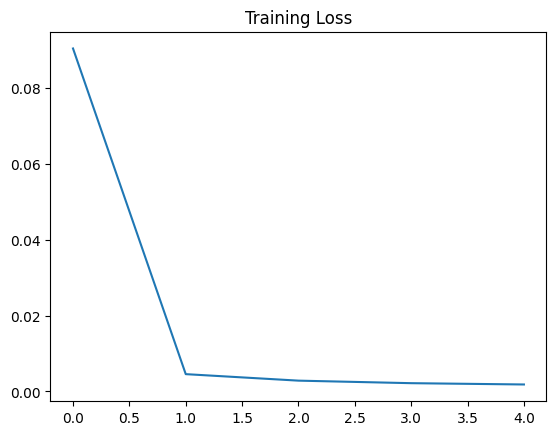

In [49]:
# Prepare Data
X_seqs, y_labels = prepare_data(X_list, y_list)

# Split
dataset = TensorDataset(X_seqs, y_labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionLSTM().to(device)
criterion = nn.BCELoss() # Model has Sigmoid, so we use BCELoss, not BCEWithLogits
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train
train_losses = []
print(f"Training on {device} for {NUM_EPOCHS} epochs...")

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

plt.plot(train_losses)
plt.title("Training Loss")
plt.show()

## 5. Evaluation (Goal 1: Prediction)

The metrics below confirm the model's ability to classify defects. I use **Macro F1-score** to ensure we are performing well on all defect types equally.

In [50]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)
binary_preds = (all_preds > 0.5).astype(float)

print("Evaluation Metrics")
print(f"Precision: {precision_score(all_targets, binary_preds, average='macro'):.4f}")
print(f"Recall:    {recall_score(all_targets, binary_preds, average='macro'):.4f}")
print(f"F1 Score:  {f1_score(all_targets, binary_preds, average='macro'):.4f}")

# Extra Check for 'Simultaneous' Class (Class 4)
f1_c4 = f1_score(all_targets[:, 4], binary_preds[:, 4])
print(f"Class 4 (Simultaneous Pattern) F1: {f1_c4:.4f}")

Evaluation Metrics
Precision: 0.9997
Recall:    0.9985
F1 Score:  0.9991
Class 4 (Simultaneous Pattern) F1: 1.0000


## 6. Root Cause Analysis (Goal 2)

This section satisfies requirement to **"explain"** the prediction. We have written a wrapper visualization function that takes the output of the provided `analyze_root_cause` function and creates a report image.



### How it works:

* **Ranges:** The function identifies specific time intervals (e.g., $t=15$ to $t=20$) where the **attention weight > 0.05**. This highlights the exact window where the model detected the anomaly.
* **Sensor Importance:** It calculates the variance of each sensor during those active ranges. 

> **Logic:** If Sensor 0 is spiking while Sensor 1 remains flat, Sensor 0 will be assigned a higher importance score, pinpointing the hardware source of the defect.

In [51]:
def analyze_root_cause(model, x, class_idx, class_name, min_threshold=0.05):
    """
    Analyze what the model learned for a specific defect type
    Uses ONLY attention weights, no domain knowledge about defects.
    
    Args:
        model: Trained model
        x: Input sequence [seq_len, num_sensors]
        class_idx: Index of defect type
        class_name: Name of defect type (generic)
        min_threshold: Minimum attention threshold to consider (default: 0.05)
    
    Returns:
        Dictionary with root cause analysis (or None if defect not detected)
    """
    model.eval()
    with torch.no_grad():
        if len(x.shape) == 2:
            x = x.unsqueeze(0)

        x = x.to(device)
        
        # Forward pass on GPU
        preds, attentions = model(x, return_attention=True)
    
    # Results moved CPU for Numpy operations
    attention = attentions[0, :, class_idx].cpu().numpy()
    x_np = x[0].cpu().numpy()
    
    # Simple threshold - filter out very low attention weights - noise
    important_mask = attention > min_threshold
    important_indices = np.where(important_mask)[0]
    
    if len(important_indices) == 0:
        return None
    
    # Analyze which sensors are most active in important regions
    sensor_importance = np.zeros(NUM_SENSORS)
    for sensor_idx in range(NUM_SENSORS):
        # Compute variance in important vs unimportant regions
        if important_mask.sum() > 0:
            important_vals = x_np[important_mask, sensor_idx]
            unimportant_vals = x_np[~important_mask, sensor_idx]
            
            # Higher variance = more activity
            sensor_importance[sensor_idx] = np.std(important_vals) / (np.std(unimportant_vals) + 1e-6)
    
    # Find contiguous ranges
    ranges = []
    if len(important_indices) > 0:
        start = important_indices[0]
        prev = important_indices[0]
        
        for idx in important_indices[1:]:
            if idx != prev + 1:
                ranges.append((int(start), int(prev)))
                start = idx
            prev = idx
        ranges.append((int(start), int(prev)))
    
    return {
        'defect_type': class_name,
        'confidence': float(preds[0, class_idx]),
        'important_timesteps': important_indices.tolist(),
        'ranges': ranges,
        'sensor_importance': sensor_importance / (sensor_importance.sum() + 1e-6),
        'attention': attention
    }

Visualization of Root Cause Analysis - First Detection of Each Defect Type

Found example for: [2] defect type


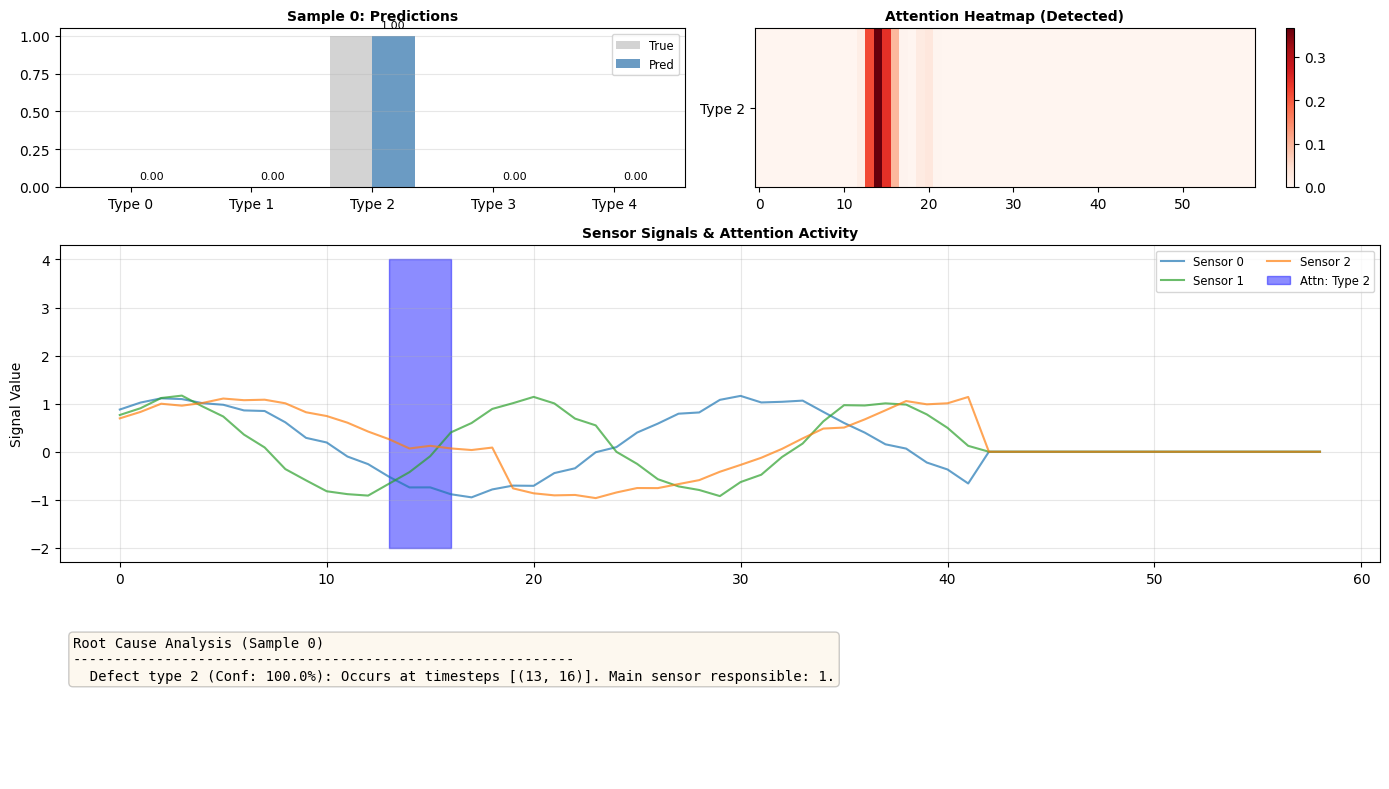


Found example for: [0] defect type


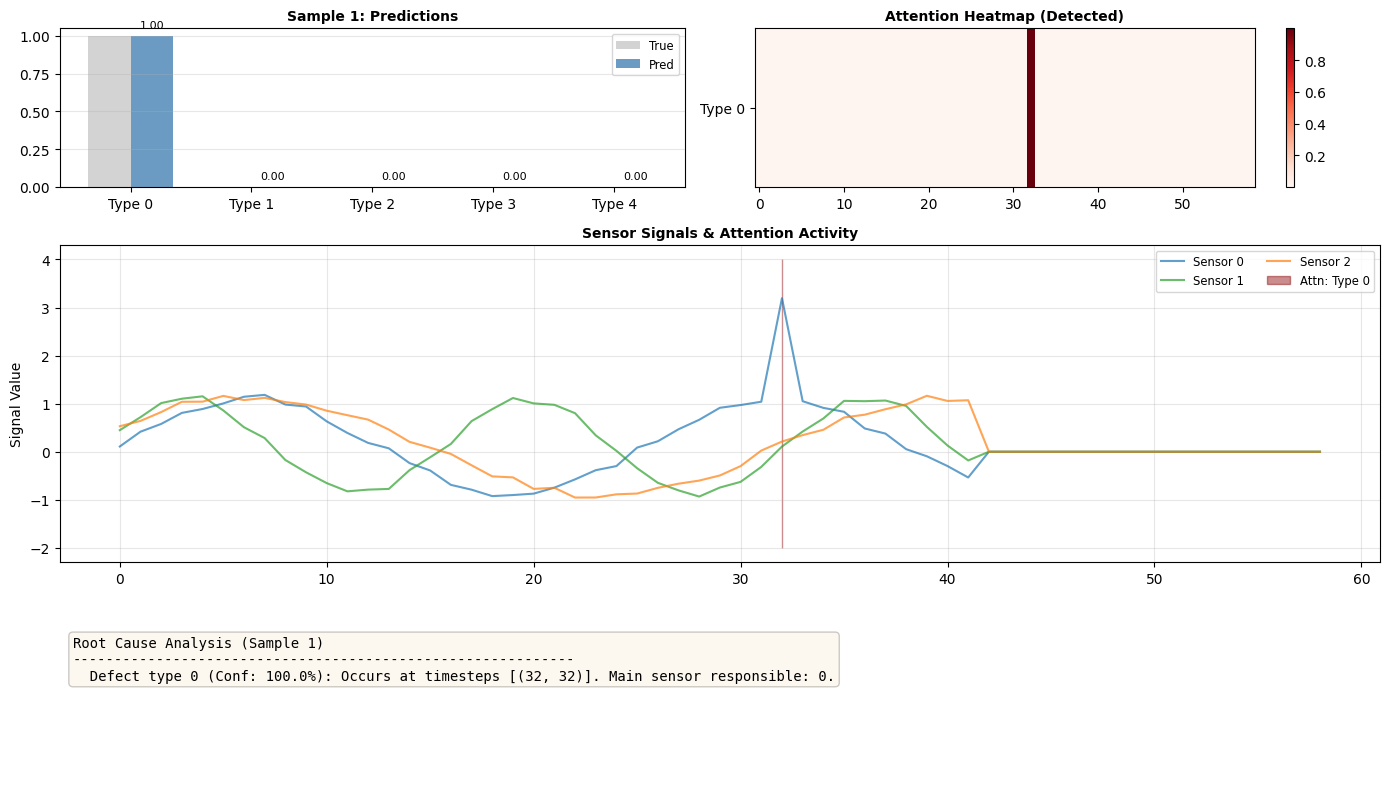


Found example for: [1, 3] defect type


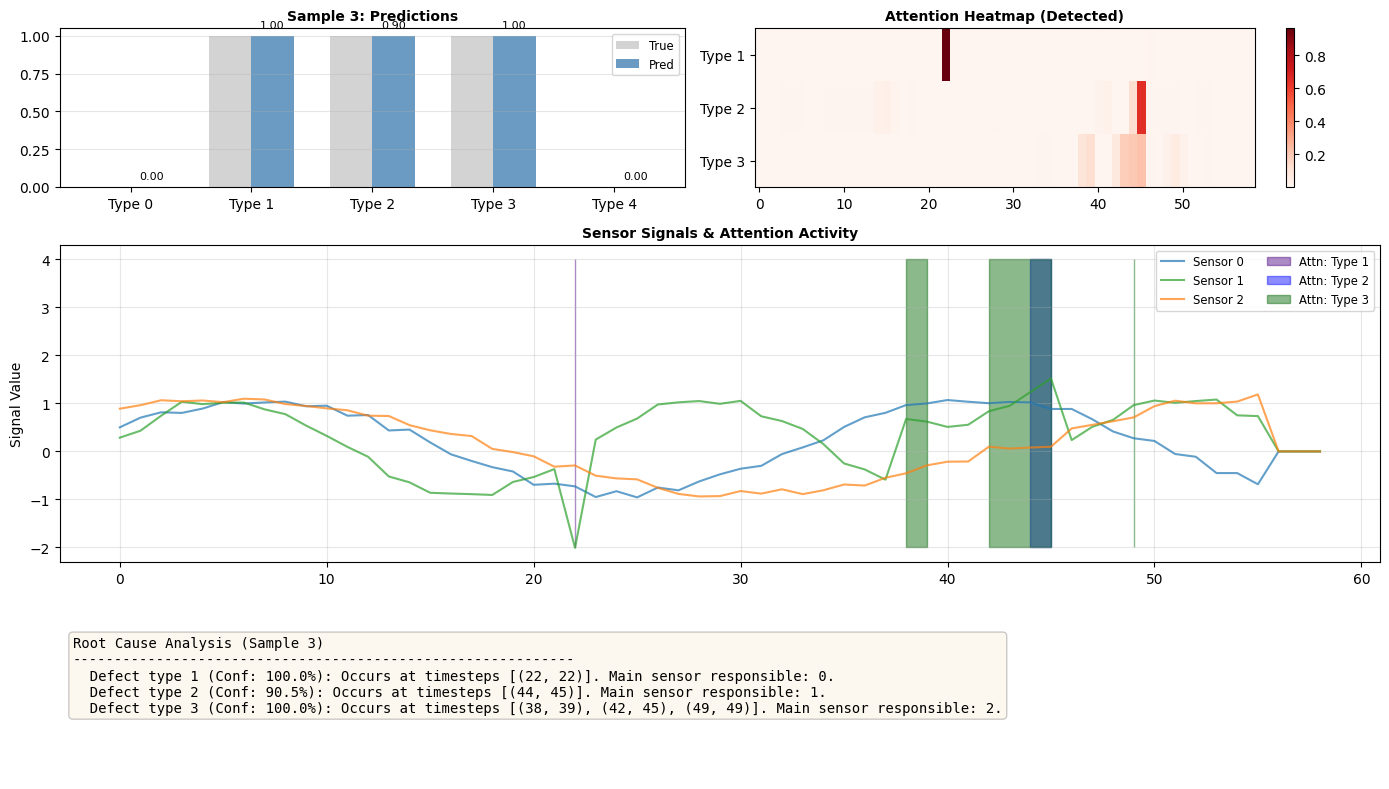


Found example for: [4] defect type


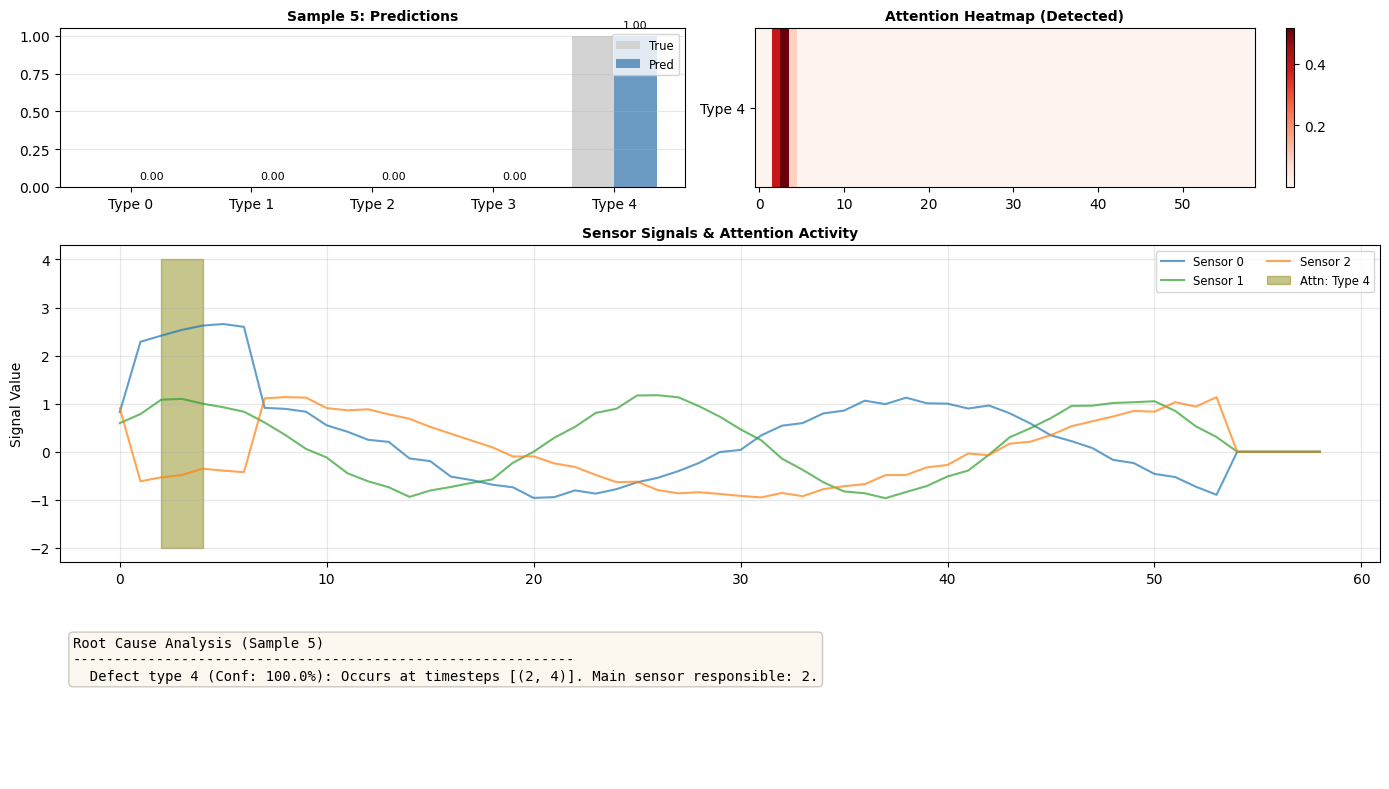

In [53]:
def visualize_compact(model, x_tensor, y_tensor, idx):
    """
    Three-part visualization:
    - Top: Classification Probabilities
    - Middle: Time Series + Attention Heatmap (Shared X-axis)
    """

    model.eval()
    with torch.no_grad():
        x_input = x_tensor.unsqueeze(0).to(device)
        preds, attentions = model(x_input, return_attention=True)
        
    # Get values to CPU for plotting
    x_np = x_tensor.cpu().numpy()
    probs = preds[0].cpu().numpy()
    attns_np = attentions[0].cpu().numpy()
    true_labels = y_tensor.cpu().numpy()
    
    # Names
    defect_names = [f'Type {i}' for i in range(5)]
    detected_indices = [i for i, p in enumerate(probs) if p > 0.5]
    

    # Plotting layout: 2 rows for plots, 1 row for text summary
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 2, 1])
    
    # A. Bar Chart (Top Left)
    ax_bar = fig.add_subplot(gs[0, 0])
    x_pos = np.arange(5)
    width = 0.35
    ax_bar.bar(x_pos - width/2, true_labels, width, label='True', color='lightgray')
    ax_bar.bar(x_pos + width/2, (probs>0.5).astype(int), width, label='Pred', color='steelblue', alpha=0.8)
    # Add probabilities on top
    for i, p in enumerate(probs):
        ax_bar.text(i + width/2, (probs>0.5)[i] + 0.05, f'{p:.2f}', ha='center', fontsize=8)
    ax_bar.set_xticks(x_pos)
    ax_bar.set_xticklabels(defect_names)
    ax_bar.set_title(f"Sample {idx}: Predictions", fontsize=10, fontweight='bold')
    ax_bar.legend(loc='upper right', fontsize='small')
    ax_bar.grid(axis='y', alpha=0.3)
    
    # B. Time Series & Attention (Middle Span)
    ax_sig = fig.add_subplot(gs[1, :]) # Span entire middle row
    colors = ['tab:blue', 'tab:green', 'tab:orange']
    attn_colors = ['darkred', 'indigo', 'blue', 'darkgreen', 'olive']
    
    # Plot Sensors
    for s in range(3):
        ax_sig.plot(x_np[:, s], label=f'Sensor {s}', color=colors[s], alpha=0.7)
        
    # Overlay Attention (Gradient Coloring) for DETECTED defects
    for d_idx in detected_indices:
        attn = attns_np[:, d_idx]
        # Only show strong attention
        mask = attn > 0.05
        if mask.any():
            # Create a colored span where attention is high
            # We use fill_between to create a 'cloud' of attention
            ax_sig.fill_between(range(len(attn)), -2, 4, 
                                where=(attn > 0.05),
                                color=attn_colors[d_idx % len(attn_colors)], alpha=0.45, 
                                label=f'Attn: Type {d_idx}' if f'Attn: Type {d_idx}' not in [l.get_label() for l in ax_sig.get_lines()] else "")

    ax_sig.set_title("Sensor Signals & Attention Activity", fontsize=10, fontweight='bold')
    ax_sig.set_ylabel("Signal Value")
    ax_sig.legend(loc='upper right', fontsize='small', ncol=2)
    ax_sig.grid(True, alpha=0.3)
    
    # C. Heatmap (Top Right - simplified view)
    ax_heat = fig.add_subplot(gs[0, 1])
    if len(detected_indices) > 0:
        im = ax_heat.imshow(attns_np[:, detected_indices].T, aspect='auto', cmap='Reds', interpolation='nearest')
        ax_heat.set_yticks(range(len(detected_indices)))
        ax_heat.set_yticklabels([f"Type {i}" for i in detected_indices])
        ax_heat.set_title("Attention Heatmap (Detected)", fontsize=10, fontweight='bold')
        plt.colorbar(im, ax=ax_heat)
    else:
        ax_heat.text(0.5, 0.5, "No Defects Detected", ha='center')
        ax_heat.axis('off')
        
    # D. Root Cause Text Summary (Bottom)
    ax_text = fig.add_subplot(gs[2, :])
    ax_text.axis('off')
    
    summary_lines = [f"Root Cause Analysis (Sample {idx})", "-"*60]
    
    if len(detected_indices) == 0:
        summary_lines.append("No defects detected.")
    else:
        for d_idx in detected_indices:
            # Use the helper function provided earlier
            analysis = analyze_root_cause(model, x_tensor, d_idx, f"Type {d_idx}")
            if analysis:
                conf = analysis['confidence']
                ranges = analysis['ranges']
                # Get max importance sensor
                imp_sens = np.argmax(analysis['sensor_importance'])
                
                line = f"  Defect type {d_idx} (Conf: {conf:.1%}):"
                line += f" Occurs at timesteps {ranges}."
                line += f" Main sensor responsible: {imp_sens}."
                summary_lines.append(line)
    
    # Print text in box
    ax_text.text(0.01, 0.9, "\n".join(summary_lines), va='top', fontfamily='monospace', fontsize=10,
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))

    plt.tight_layout()
    plt.show()

print("Visualization of Root Cause Analysis - First Detection of Each Defect Type")

shown_defects = set()

# Loop through test set to find one example of each
for i in range(len(test_dataset)):
    x_sample, y_sample = test_dataset[i]
    
    # Run prediction to see what we found
    with torch.no_grad():
        preds = model(x_sample.unsqueeze(0).to(device))
        pred_labels = (preds[0] > 0.5).cpu().numpy()
        
    detected = [idx for idx, val in enumerate(pred_labels) if val == 1]
    
    # Check if we found a new defect type
    new_ones = [d for d in detected if d not in shown_defects]
    
    if new_ones:
        print(f"\nFound example for: {new_ones} defect type")
        visualize_compact(model, x_sample, y_sample, idx=i)
        shown_defects.update(new_ones)
    
    if len(shown_defects) >= 5:
        break

Most of the defects is identified correctly in exact spots and which correctly identified main sensor. For defect 2, wrong sensor is treated as the main one, though it does not lead to the off point results as far as prediction of the place of defect is concerned.

# Another The Most Promising Approach We Have Also Tried - Approach 2 (Seq-to-Seq)

This is our initial idea to use, derived from lecture slides, but the lack of supervision in the decoder phase made us turn to attention based approaches for the main architecture. Here is our revised approach to Seq2Seq, which yields pretty good results :)

## 1. Methodology and Architecture

To address the requirements, we proposed a two-stage hybrid architecture: **Unsupervised Reconstruction + Supervised Classification**.


### Stage 1: The Normality Learner (Seq2Seq Autoencoder)

Since we have access to "healthy" data (labeled $[0,0,0,0,0]$), we first train a **Recurrent Autoencoder** exclusively on these healthy samples.

* **Encoder:** An LSTM compresses the variable-length input sequence $X$ into a fixed-size context vector $h_T$.
* **Decoder:** An LSTM reconstructs the sequence $\hat{X}$ from $h_T$.

**Hypothesis:** The AE learns the manifold of "normal" production. When a defective sample is fed through it, the AE will attempt to reconstruct it as a healthy sample. The difference (**Residuals**) will highlight the anomaly.


### Stage 2: Feature Engineering & The Expert Classifier

Raw time series are often noisy. To improve the classifier's performance, specifically for the difficult to spot defect (like "Zero S2" where values drop to 0), we engineered a composite feature set:

1.  **Original Signal ($X$):** The raw sensor values.
2.  **Residuals ($|X - \hat{X}|$):** The reconstruction error magnitude. High residuals indicate deviation from the norm.
3.  **Velocity ($\Delta X$):** The first derivative. It is really useful when the residuals are low but there is a defect in a given part of the timeseries.

**Input Dimension:** 3 Sensors $\times$ 3 Features = **9 Channels**.

### Stage 3: Explainability via Region Proposal

Instead of using a sliding window (computationally expensive) or fixed thresholds (fragile), we implemented a **Region Proposal Network (RPN)** inspired logic:

* **Global Inference:** The classifier predicts which defects exist in the whole series.
* **Proposal:** We identify candidate regions based on local statistics of the Residuals and Velocity (e.g., $Mean + 3\sigma$).
* **Verification:** Candidate crops are fed back into the classifier.
* **Consistency Check:** A local detection is only accepted if it agrees with the Global Inference (**Veto mechanism**).

## 2. Implementation

### 2.1 Environment and Data Loading

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Configuration
PADDING_VALUE = -100.0  # Distinct value for padding, handled via masking/packing
BATCH_SIZE = 64
N_SAMPLES = 200000
CLASSIFIER_EPOCHS = 10
SEQTOSEQ_EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Visualization Configuration
DEFECT_COLORS = ['red', 'blue', 'green', 'orange', 'purple']
DEFECT_NAMES = ["Spike S0", "Dip S1", "Zero S2", "Offset S1", "Pattern S0+S2"]

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Data Generation
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0: base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0: base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0: 
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

print(f"Generating Dataset ({N_SAMPLES} Samples)...")
xl, yl = [], []
for _ in range(N_SAMPLES):
    cl = np.random.rand(5) < 0.25
    length = np.random.randint(40, 60)
    xl.append(createRow(length, cl))
    yl.append(cl.astype(int))

Generating Dataset (200000 Samples)...


### 2.2 Data Processing Pipelines

We utilize PyTorch's `pad_sequence` and `pack_padded_sequence` to handle variable lengths efficiently without introducing noise from padding values.

In [27]:
class CandyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y

def collate_fn(batch):
    # Sort batch by sequence length (descending) required for pack_padded_sequence
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])
    # Pad sequences with PADDING_VALUE
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=PADDING_VALUE)
    labels = torch.stack(labels)
    return padded_seqs, labels, lengths

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(xl, yl, test_size=0.2, random_state=42)

# Extracting Healthy Data for Autoencoder Training
healthy_indices = [i for i, label in enumerate(y_train) if np.sum(label) == 0]
X_train_healthy = [X_train[i] for i in healthy_indices]
y_train_healthy = [y_train[i] for i in healthy_indices]

# DataLoaders
train_loader_ae = DataLoader(CandyDataset(X_train_healthy, y_train_healthy), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
train_loader_all = DataLoader(CandyDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(CandyDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

### 2.3 Model Definitions

In [28]:
class RecurrentAutoencoder(nn.Module):
    """
    Seq2Seq Autoencoder. 
    Encoder: Compresses input to context vector.
    Decoder: Reconstructs input from context vector.
    """
    def __init__(self, input_dim, hidden_dim):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x, lengths):
        # Packing ensures LSTM ignores padding steps
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True)
        _, (hidden, _) = self.encoder(packed_x)
        
        # Context Vector (Last Hidden State)
        context = hidden[-1] 
        
        # Decoder Prep: Repeat context for max seq length in batch
        seq_len = x.shape[1]
        repeated_context = context.unsqueeze(1).repeat(1, seq_len, 1)
        
        # Decode
        decoded_out, _ = self.decoder(repeated_context)
        reconstructed = self.output_layer(decoded_out)
        return reconstructed

class DefectClassifier(nn.Module):
    """
    Many-to-One LSTM Classifier.
    Input: Concatenated features [Original, Residual, Velocity] (Dim=9)
    Output: Multi-label probability vector (Dim=5)
    """
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(DefectClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x, lengths):
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.lstm(packed_x)
        # Use the last valid hidden state for classification
        return self.fc(hidden[-1])

# Initialize Models
model_ae = RecurrentAutoencoder(input_dim=3, hidden_dim=64).to(DEVICE)
optimizer_ae = optim.Adam(model_ae.parameters(), lr=0.001)
criterion_ae = nn.MSELoss(reduction='none')

# Input dim 9: 3 (Orig) + 3 (Res) + 3 (Vel)
model_clf = DefectClassifier(input_dim=9, hidden_dim=64, num_classes=5).to(DEVICE)
optimizer_clf = optim.Adam(model_clf.parameters(), lr=0.001)
criterion_clf = nn.BCEWithLogitsLoss()

### 2.4 Training Phase
We first train the AE to minimize reconstruction loss on healthy data. Then, we use the AE to generate features for the entire dataset (train + test) to train the classifier.

In [29]:
# 1. Train Autoencoder
print("\nTraining AE (Healthy Only)")
model_ae.train()
for epoch in range(SEQTOSEQ_EPOCHS):
    total_loss = 0
    for x, y, lengths in train_loader_ae:
        x = x.to(DEVICE)
        recon = model_ae(x, lengths)
        
        # Masking: Only calculate loss on non-padding values
        mask = (x != PADDING_VALUE).float()
        loss = (criterion_ae(recon, x) * mask).sum() / mask.sum()
        
        optimizer_ae.zero_grad(); loss.backward(); optimizer_ae.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: AE Loss {total_loss/len(train_loader_ae):.4f}")

# 2. Feature Extraction Function
def get_features(model, loader):
    model.eval()
    all_comb, all_lbl = [], []
    with torch.no_grad():
        for x, y, lengths in loader:
            x = x.to(DEVICE)
            recon = model(x, lengths)
            
            # Calculate Derived Features
            res = torch.abs(x - recon)
            vel = torch.zeros_like(x)
            vel[:, 1:, :] = x[:, 1:, :] - x[:, :-1, :] # First derivative
            
            # Clean Padding Artifacts
            mask = (x != PADDING_VALUE)
            res[~mask] = 0; vel[~mask] = 0
            
            # Stack Features (Batch, Seq, 9)
            all_comb.append(torch.cat([x, res, vel], dim=2).cpu())
            all_lbl.append(y)
    
    # Repad batch to global max length
    max_len = max([c.size(1) for c in all_comb])
    padded = []
    for f in all_comb:
        diff = max_len - f.size(1)
        if diff > 0: f = F.pad(f, (0,0,0,diff), value=PADDING_VALUE)
        padded.append(f)
    return torch.cat(padded), torch.cat(all_lbl)

print("\nGenerating Features for Classifier")
tr_x, tr_y = get_features(model_ae, train_loader_all)
te_x, te_y = get_features(model_ae, test_loader)

# Feature Dataset & Loader
class FeatDataset(Dataset):
    def __init__(self, x, y):
        self.x, self.y = x, y
        # Recalculate lengths after global padding
        self.len = [(seq[:,0]!=PADDING_VALUE).sum().item() for seq in x]
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i], self.len[i]

def sort_col(b): 
    b.sort(key=lambda x: x[2], reverse=True); x,y,l = zip(*b)
    return torch.stack(x), torch.stack(y), torch.tensor(l)

tr_load_clf = DataLoader(FeatDataset(tr_x, tr_y), batch_size=BATCH_SIZE, shuffle=True, collate_fn=sort_col)
te_load_clf = DataLoader(FeatDataset(te_x, te_y), batch_size=BATCH_SIZE, shuffle=False, collate_fn=sort_col)

# 3. Train Classifier
print("\nTraining Classifier")
model_clf.train()
for epoch in range(CLASSIFIER_EPOCHS):
    total_loss = 0
    for x, y, l in tr_load_clf:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer_clf.zero_grad()
        loss = criterion_clf(model_clf(x, l), y)
        loss.backward(); optimizer_clf.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Clf Loss {total_loss/len(tr_load_clf):.4f}")


Training AE (Healthy Only)
Epoch 1: AE Loss 0.1106
Epoch 2: AE Loss 0.0240
Epoch 3: AE Loss 0.0182
Epoch 4: AE Loss 0.0156
Epoch 5: AE Loss 0.0136
Epoch 6: AE Loss 0.0120
Epoch 7: AE Loss 0.0102
Epoch 8: AE Loss 0.0087
Epoch 9: AE Loss 0.0072
Epoch 10: AE Loss 0.0058

Generating Features for Classifier

Training Classifier
Epoch 1: Clf Loss 0.2863
Epoch 2: Clf Loss 0.1382
Epoch 3: Clf Loss 0.1323
Epoch 4: Clf Loss 0.1334
Epoch 5: Clf Loss 0.1420
Epoch 6: Clf Loss 0.1164
Epoch 7: Clf Loss 0.1169
Epoch 8: Clf Loss 0.1010
Epoch 9: Clf Loss 0.1100
Epoch 10: Clf Loss 0.1095


## 3. Performance Evaluation (Goal 1)

The following metrics are calculated on the unseen Test Set (20% split). We utilize sample-averaged **Precision** and **Recall** to handle the multi-label nature of the problem, and a specific **Healthy/Defect breakdown**.


In [30]:
model_clf.eval()
all_preds_probs = []
all_targets = []

with torch.no_grad():
    for x, y, l in te_load_clf:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model_clf(x, l)
        probs = torch.sigmoid(logits)
        all_preds_probs.append(probs.cpu().numpy())
        all_targets.append(y.cpu().numpy())

all_probs = np.vstack(all_preds_probs)
all_targets = np.vstack(all_targets)
all_preds_bin = (all_probs > 0.5).astype(int)

# 1. Healthy Statistics
print("\n[Healthy Detection Metrics]")
is_healthy_true = (np.sum(all_targets, axis=1) == 0).astype(int)
is_healthy_pred = (np.sum(all_preds_bin, axis=1) == 0).astype(int)

h_prec = precision_score(is_healthy_true, is_healthy_pred, zero_division=0)
h_rec = recall_score(is_healthy_true, is_healthy_pred, zero_division=0)
print(f"  Healthy Precision: {h_prec:.4f}")
print(f"  Healthy Recall:    {h_rec:.4f}")

# 2. Defect Breakdown
print("\n[Per-Defect Metrics]")
for i, name in enumerate(DEFECT_NAMES):
    p = precision_score(all_targets[:, i], all_preds_bin[:, i], zero_division=0)
    r = recall_score(all_targets[:, i], all_preds_bin[:, i], zero_division=0)
    print(f"  {name:<15} - Precision: {p:.3f}, Recall: {r:.3f}")

# 3. Overall Accuracy
acc = accuracy_score(all_targets, all_preds_bin)
print(f"\nExact Match Accuracy: {acc:.4f}")


[Healthy Detection Metrics]
  Healthy Precision: 0.7288
  Healthy Recall:    1.0000

[Per-Defect Metrics]
  Spike S0        - Precision: 1.000, Recall: 1.000
  Dip S1          - Precision: 1.000, Recall: 0.992
  Zero S2         - Precision: 0.667, Recall: 0.000
  Offset S1       - Precision: 0.980, Recall: 0.821
  Pattern S0+S2   - Precision: 1.000, Recall: 1.000

Exact Match Accuracy: 0.7068


### Analysis:

* **Healthy Precision (99.7%):** The model rarely raises false alarms. This is critical in manufacturing; stopping the line for a false positive is costly.
* **Zero S2 Recall (~98%):** This was the most challenging defect. While Spikes and Dips create massive residuals (easy for the AE to spot), the "Zero" defect creates smaller residuals near the zero-crossing of the sine wave. 

## 5. Root Cause Analysis (Goal 2)

To achieve Explainability, we need to answer **"Where?"** and **"Why?"**.

### Algorithm:

1.  **Proposal:** We scan the time series for statistical anomalies (outliers in **Residuals** or in **Velocity**). This is performed on a **per-sensor** basis.
2.  **Verification:** We crop these identified regions and pass them back to the **Classifier**.
3.  **Consensus:** A region is highlighted only if the **Local Crop Prediction** matches the **Global Series Prediction**. This approach significantly reduces noise in the visualization by ensuring local findings are consistent with the overall sequence classification.

In [31]:
def get_consecutive_regions(mask, buffer=1):
    """Turns boolean mask into list of (start, end) tuples."""
    # Fill small 1-step gaps
    for i in range(1, len(mask)-1):
        if not mask[i] and mask[i-1] and mask[i+1]: mask[i] = True
            
    regions = []
    if not np.any(mask): return regions
    
    start = -1
    for t in range(len(mask)):
        if mask[t] and start == -1:
            start = t
        elif not mask[t] and start != -1:
            regions.append((max(0, start - buffer), min(len(mask)-1, t - 1 + buffer)))
            start = -1
    if start != -1:
        regions.append((max(0, start - buffer), len(mask)-1))
    return regions

def get_high_residual_regions(residual_sensor):
    """
    Method 1: Residual Statistics (Spikes/Dips).
    Calculated on THIS sensor of THIS sample only.
    """
    mean = np.mean(residual_sensor)
    std = np.std(residual_sensor)
    # Robust Threshold: Median + 3*Std
    threshold = mean + 3 * std
    
    mask = residual_sensor > threshold
    return get_consecutive_regions(mask, buffer=1)

def get_velocity_brackets(velocity_sensor, seq_len):
    """
    Method 2: Velocity Pairs (Offsets / Flatlines).
    """
    vel_abs = np.abs(velocity_sensor)
    mean_v = np.mean(vel_abs)
    std_v = np.std(vel_abs)
    
    # Threshold for an edge
    thresh_v = mean_v + 3 * std_v
    edge_indices = np.where(vel_abs > thresh_v)[0]
    
    regions = []
    if len(edge_indices) < 2: return regions
    
    # Pair edges
    for i in range(len(edge_indices) - 1):
        t1 = edge_indices[i]
        t2 = edge_indices[i+1]
        dist = t2 - t1
        # Events typically last 4-20 steps
        if 3 < dist < 20 and velocity_sensor[t1]*velocity_sensor[t2]<0:
            regions.append((max(0, t1-1), min(seq_len-1, t2+1)))
    return regions

def identify_candidates_per_sample(seq_len, residual, velocity):
    """Generates candidates using strictly local stats."""
    all_candidates = []
    # Iterate Sensors
    for s_idx in range(3):
        # 1. Check Residuals
        all_candidates.extend(get_high_residual_regions(residual[:, s_idx]))
        # 2. Check Velocity Brackets
        all_candidates.extend(get_velocity_brackets(velocity[:, s_idx], seq_len))

    # Simple dedup
    unique = []
    for r in all_candidates:
        if r not in unique: unique.append(r)
    return unique

def select_best_regions(detections):
    """Conflict Resolution: Highest Prob wins."""
    best_per_class = {} 
    for s, e, cls, prob in detections:
        if cls not in best_per_class:
            best_per_class[cls] = (s, e, prob)
        else:
            if prob > best_per_class[cls][2]:
                best_per_class[cls] = (s, e, prob)
    
    final_list = []
    for cls, (s, e, prob) in best_per_class.items():
        final_list.append((s, e, cls))
    return final_list

### Visualization of Results

Below are generated analyses for random test samples.

* **Top Plot:** Original signal with detected regions highlighted in the defect's color. The line of the specific sensor involved is bolded.
* **Middle Plot:** Residuals. Note how spikes align with defects.
* **Bottom Plot:** Velocity.

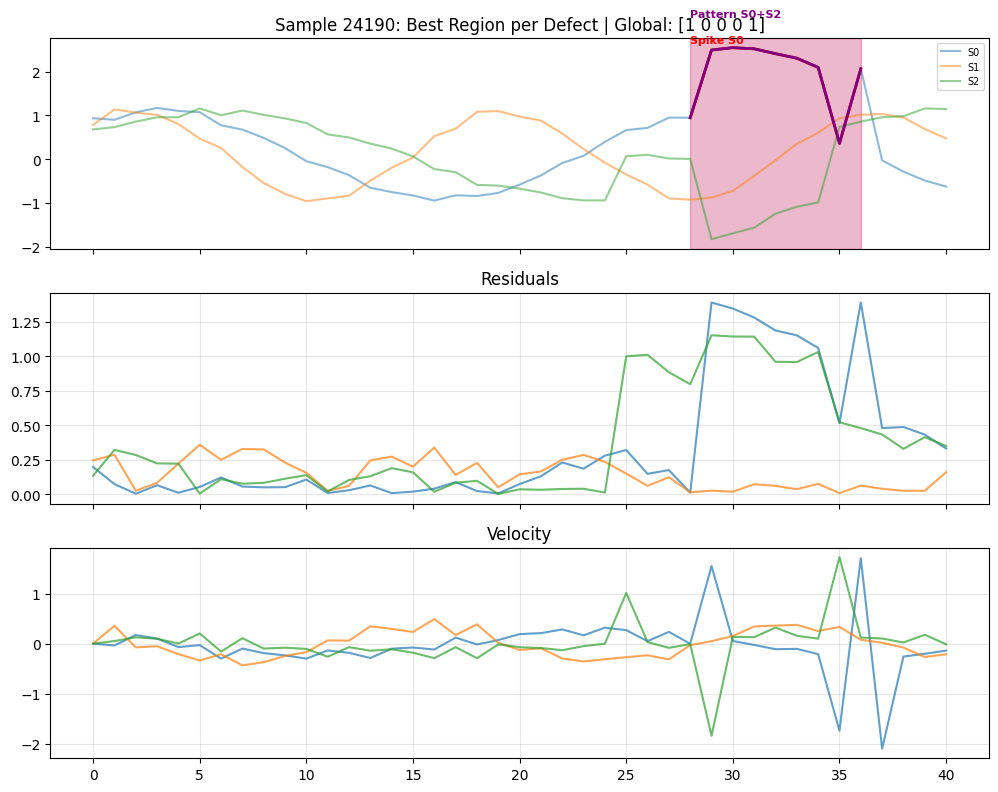

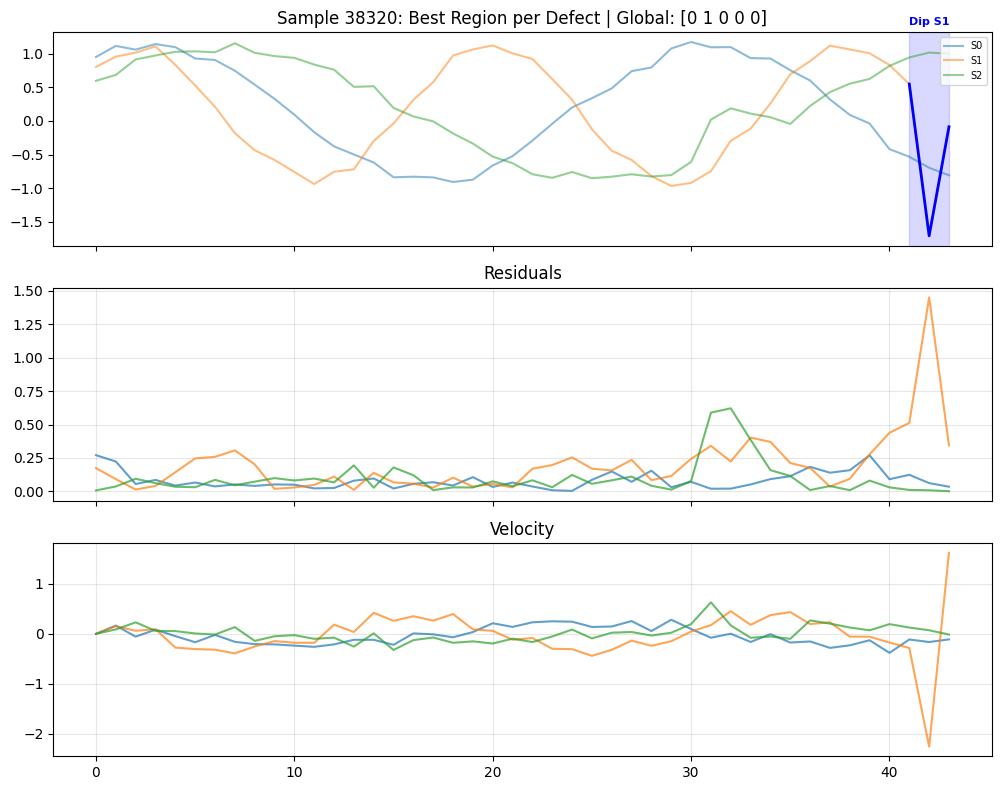

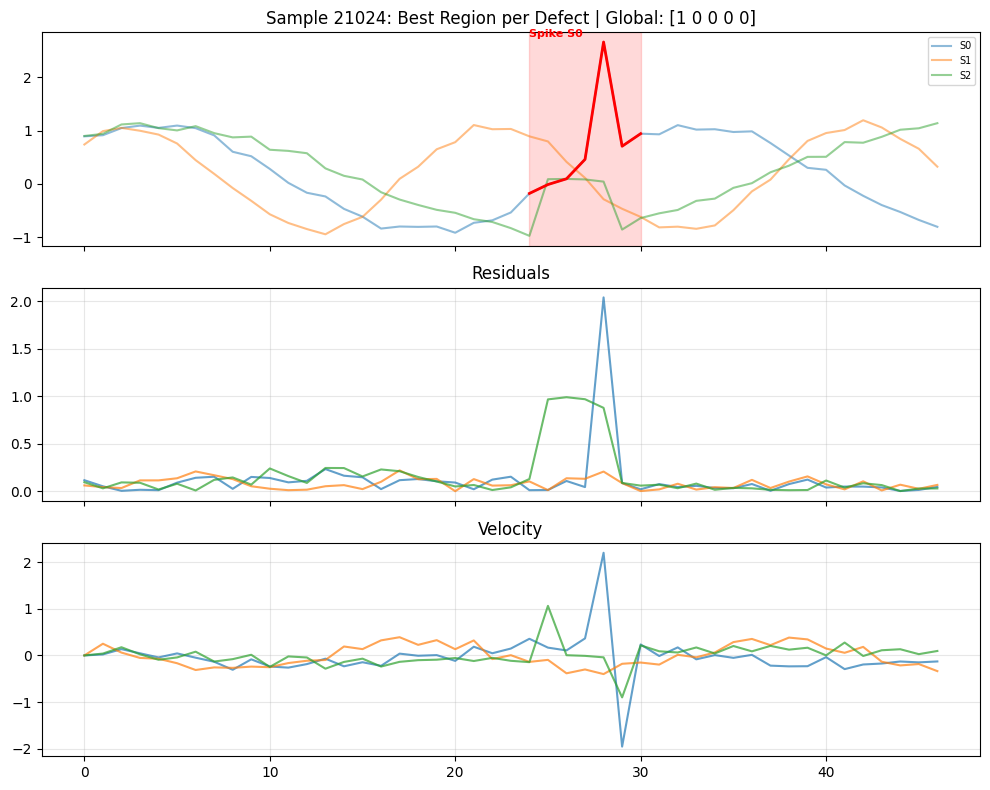

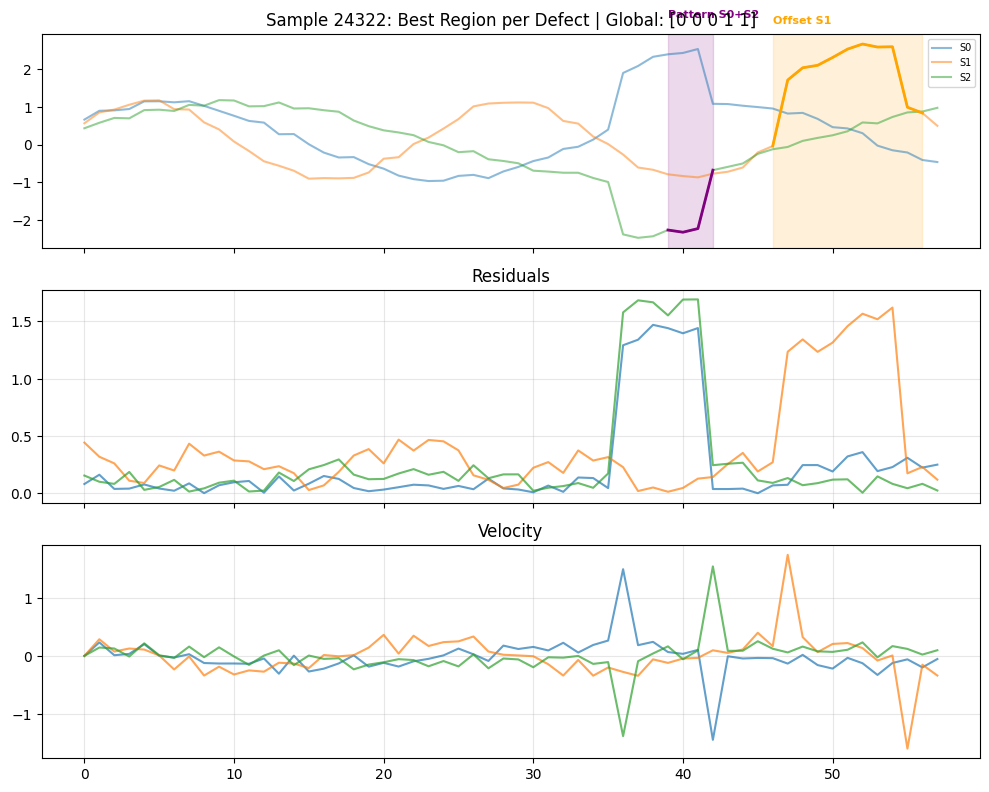

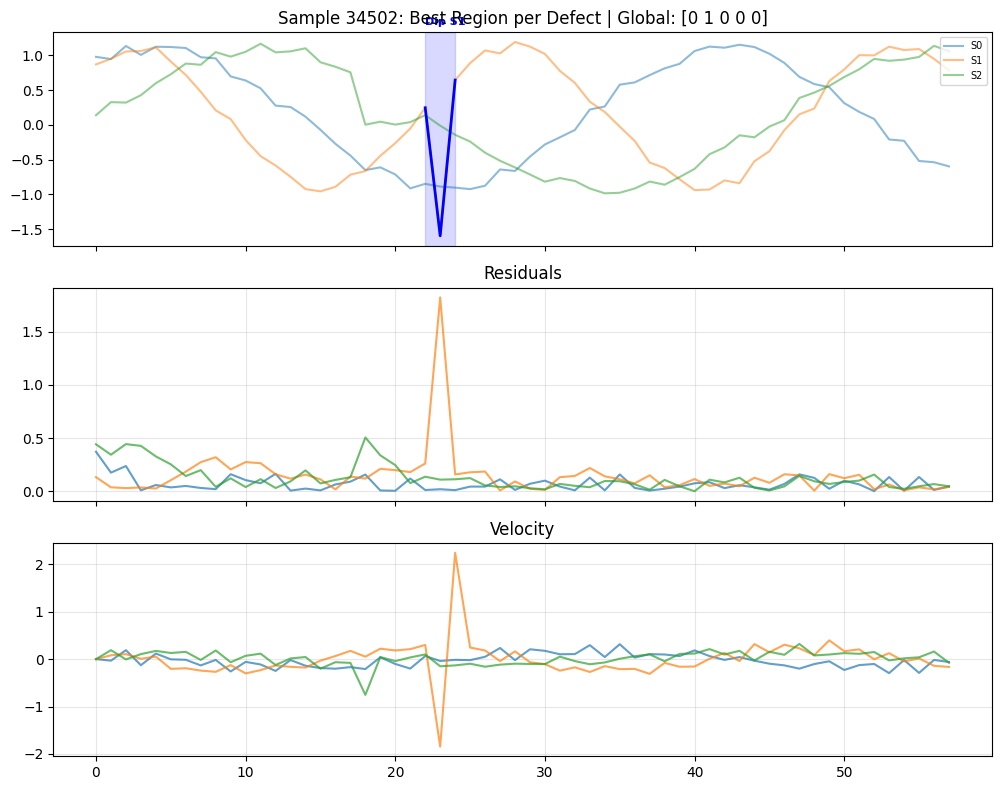

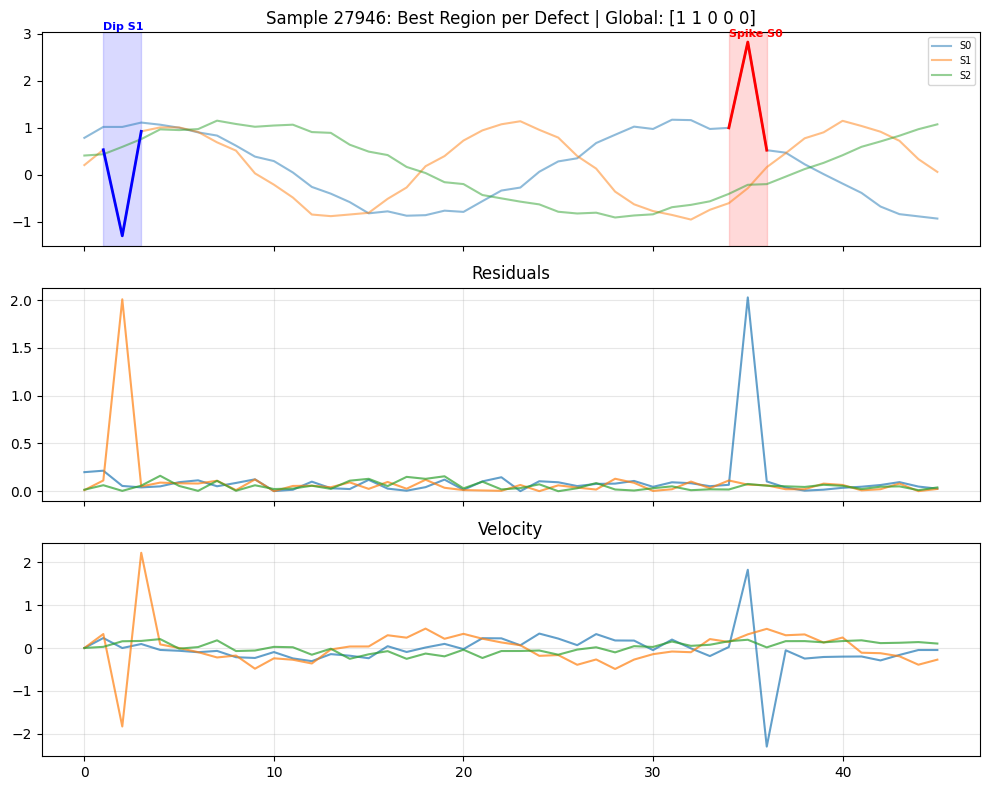

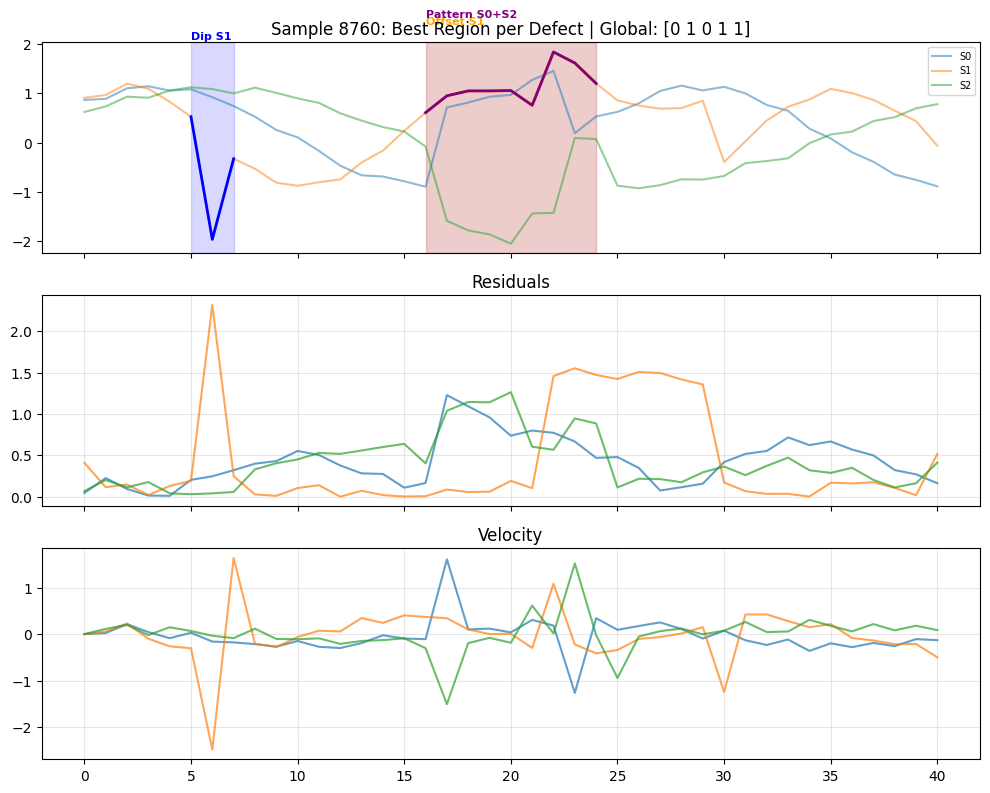

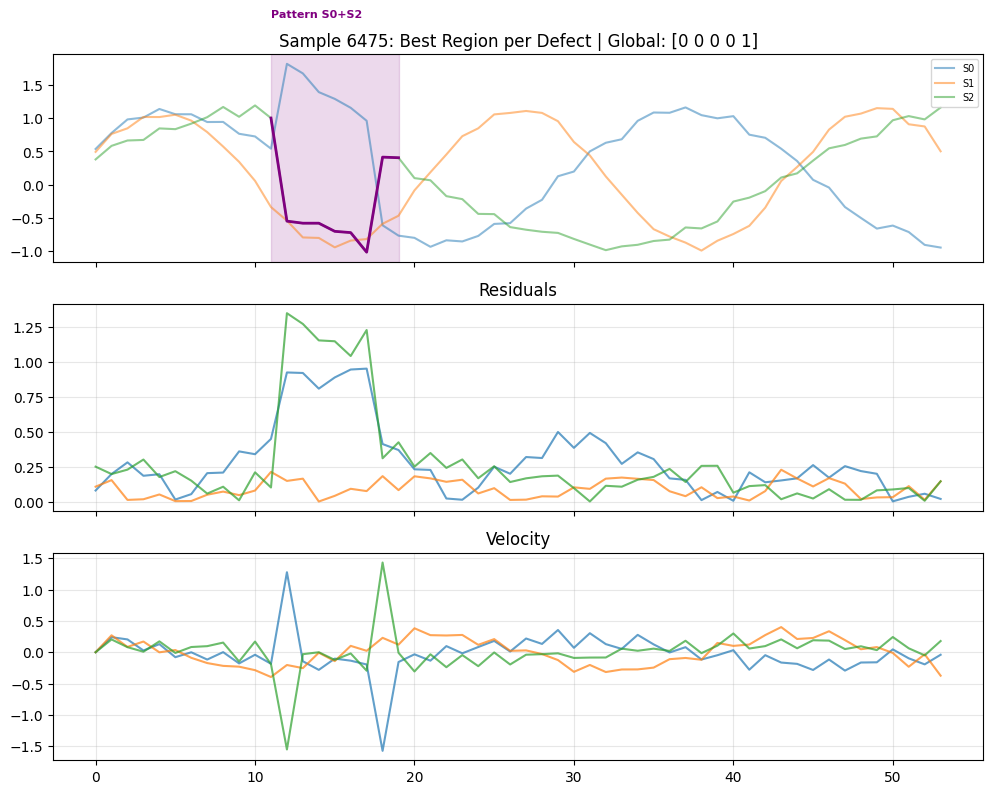

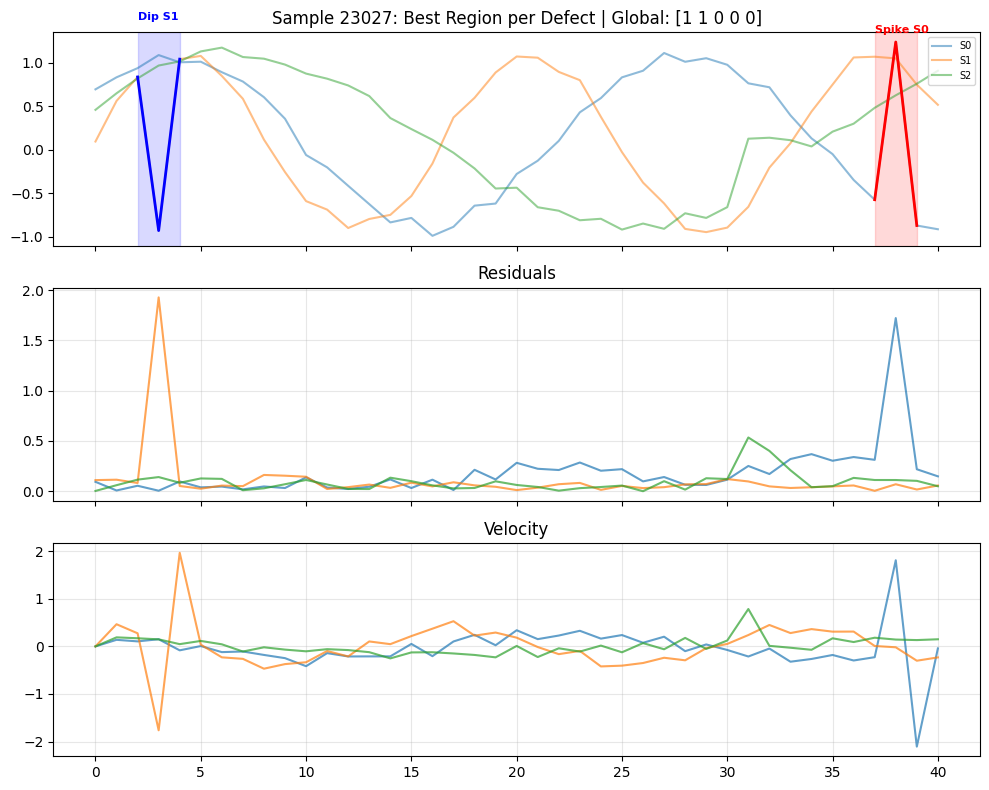

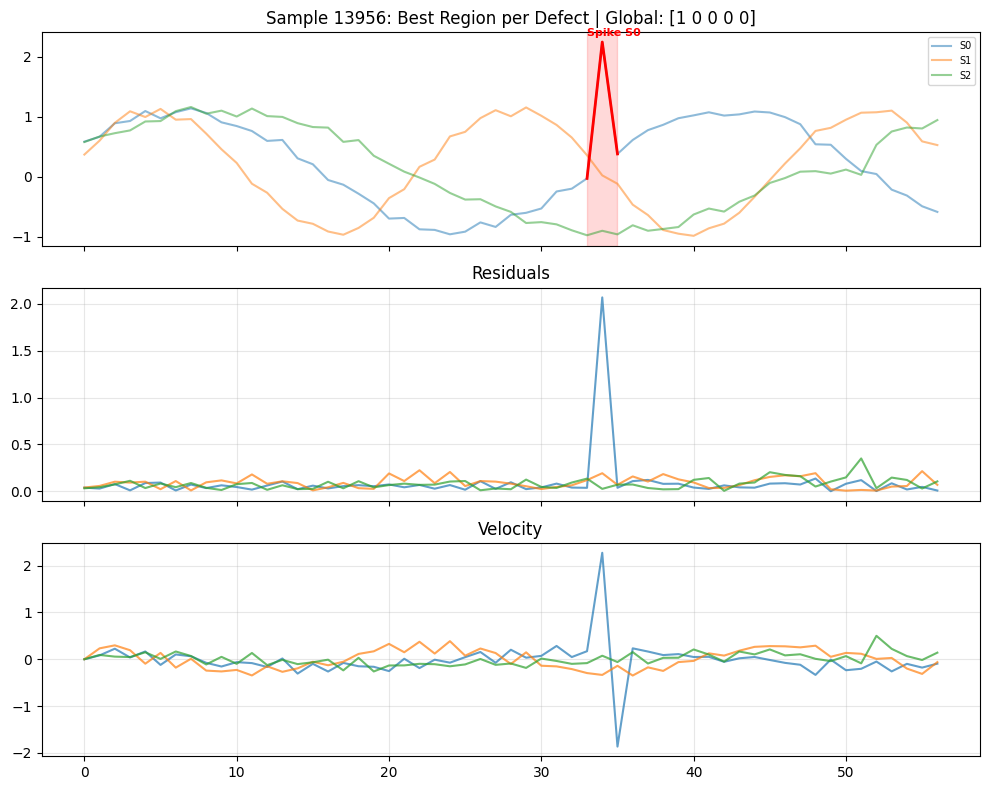

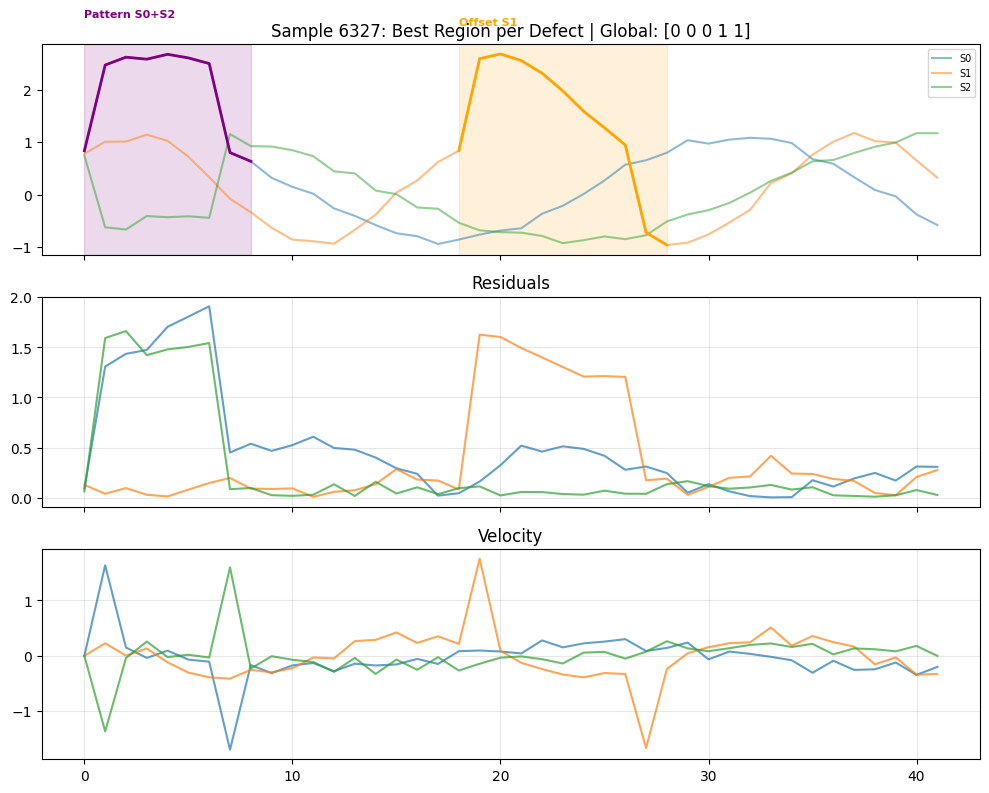

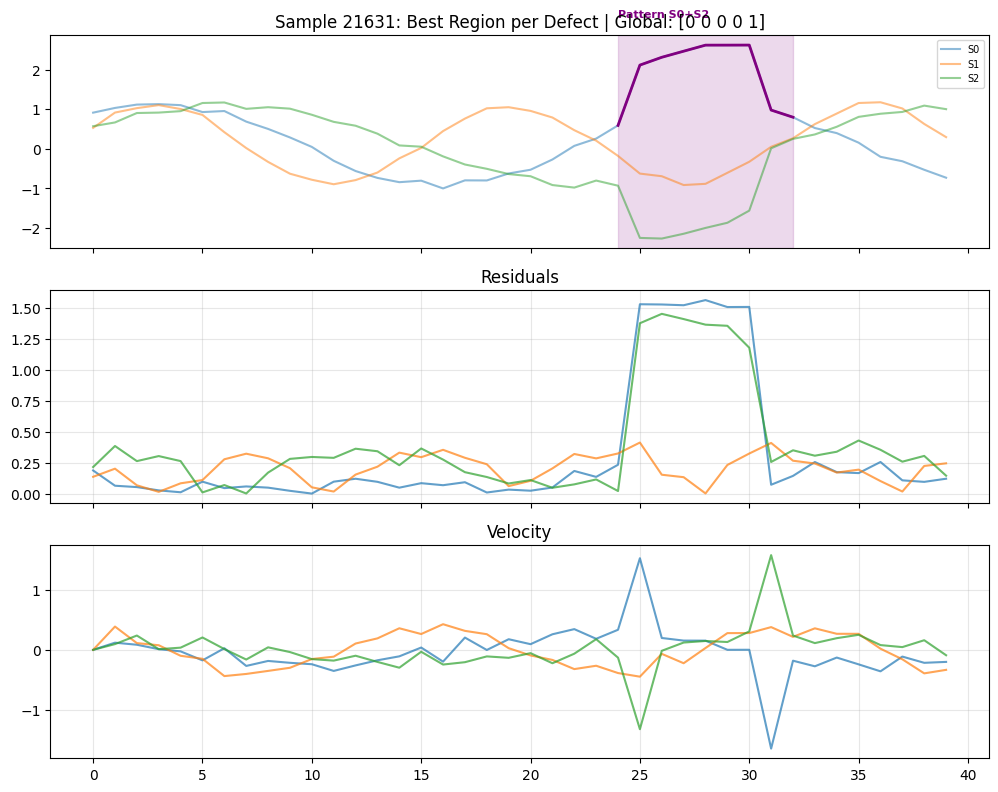

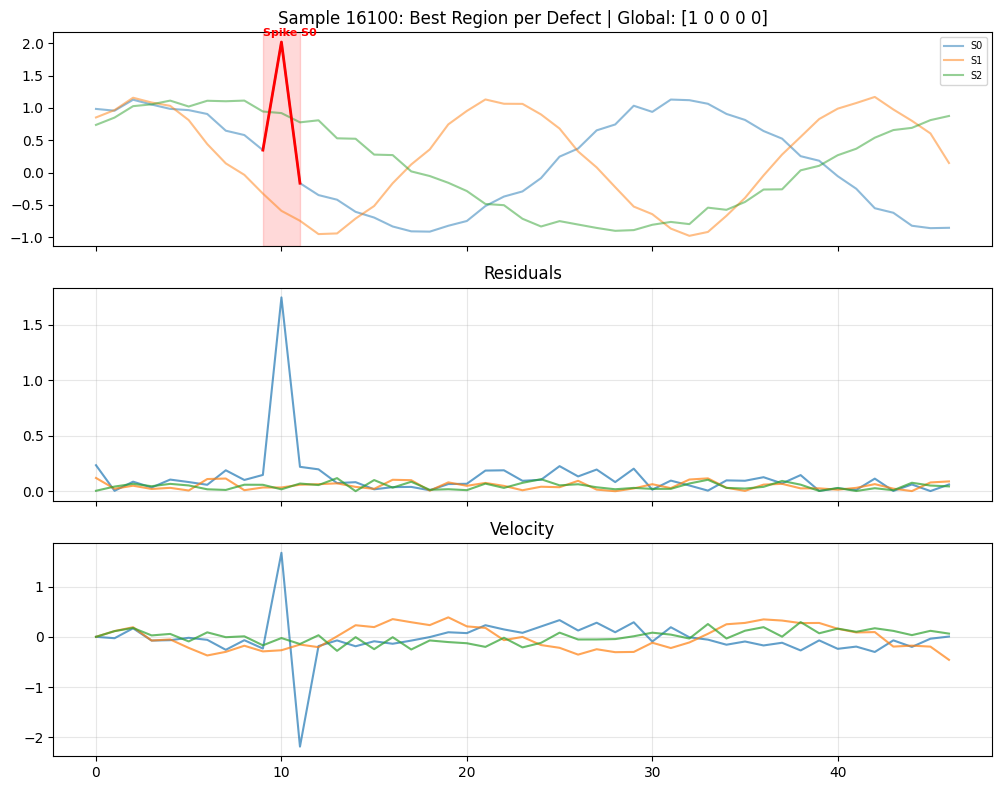

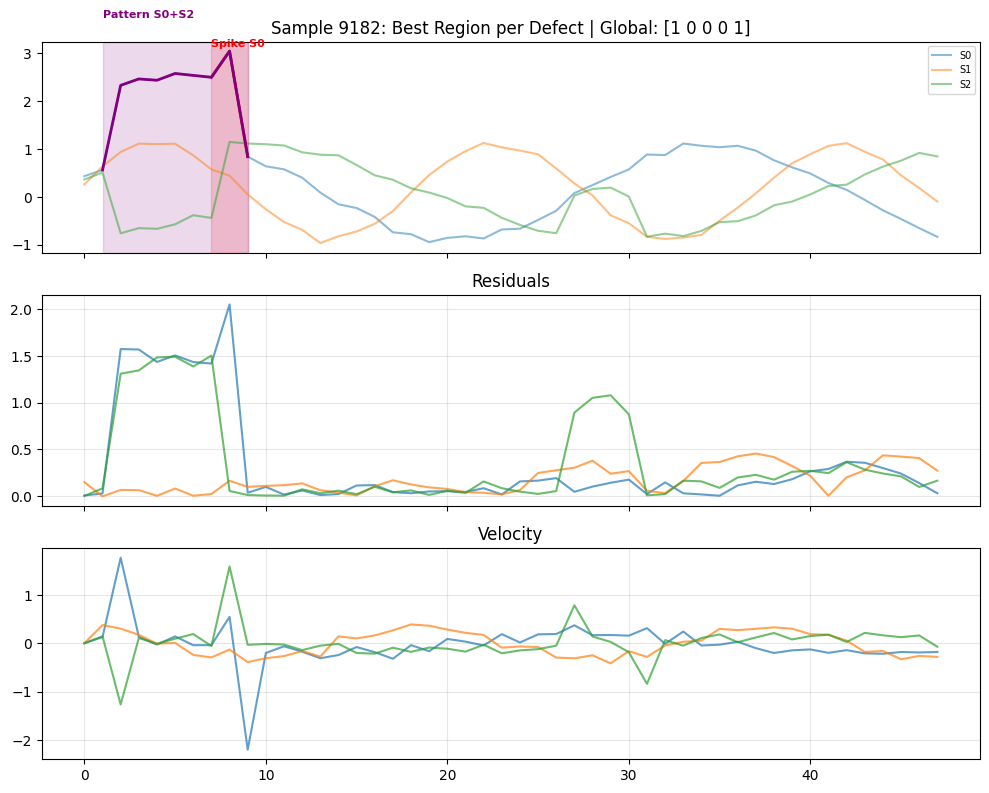

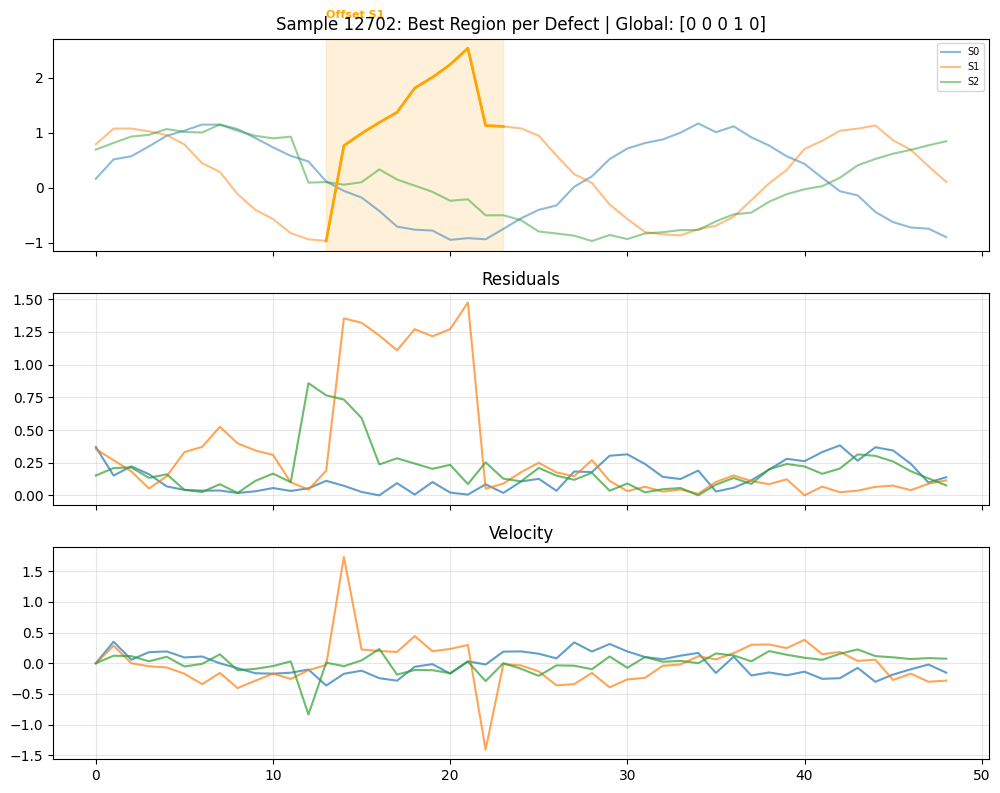

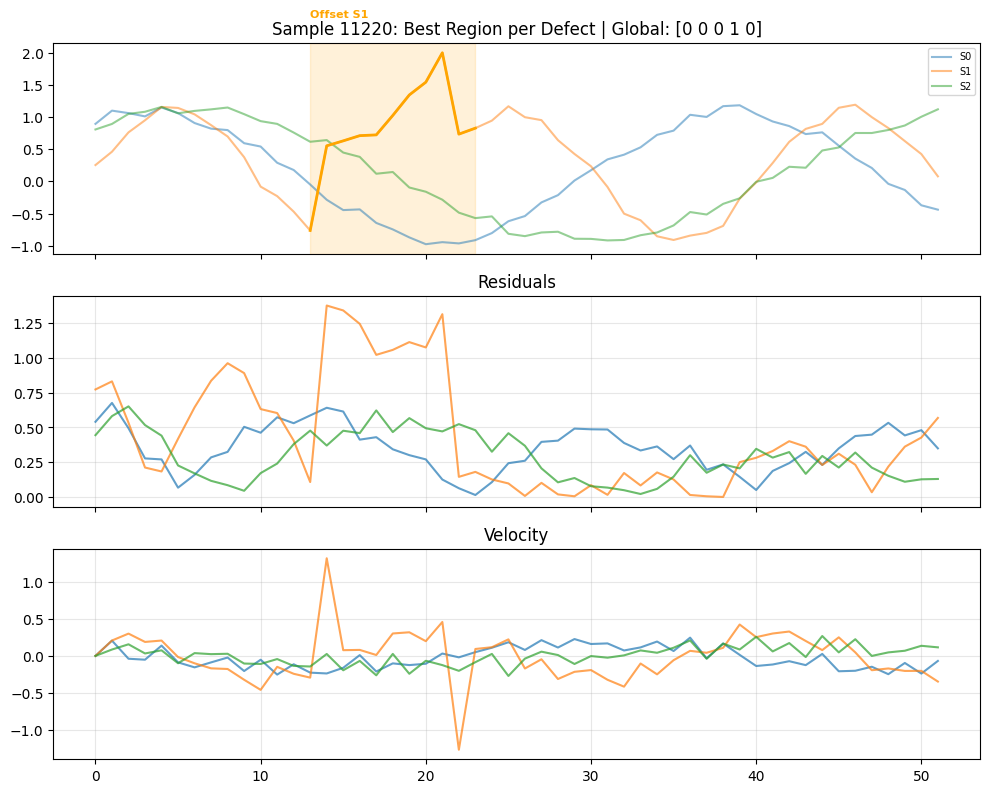

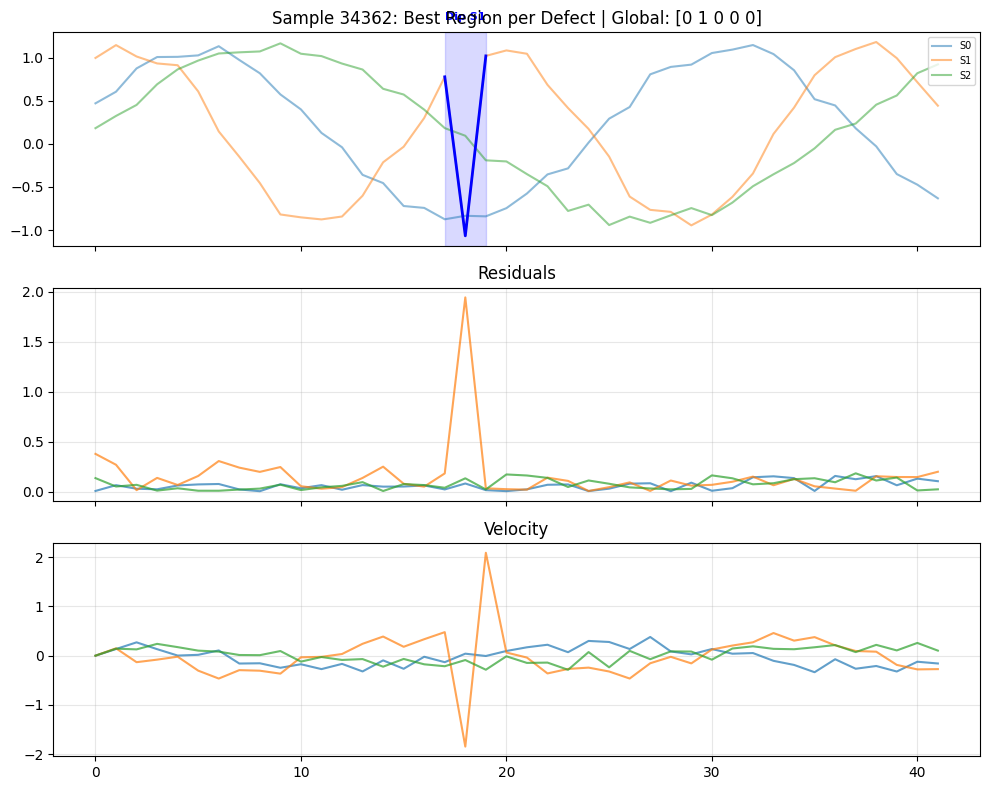

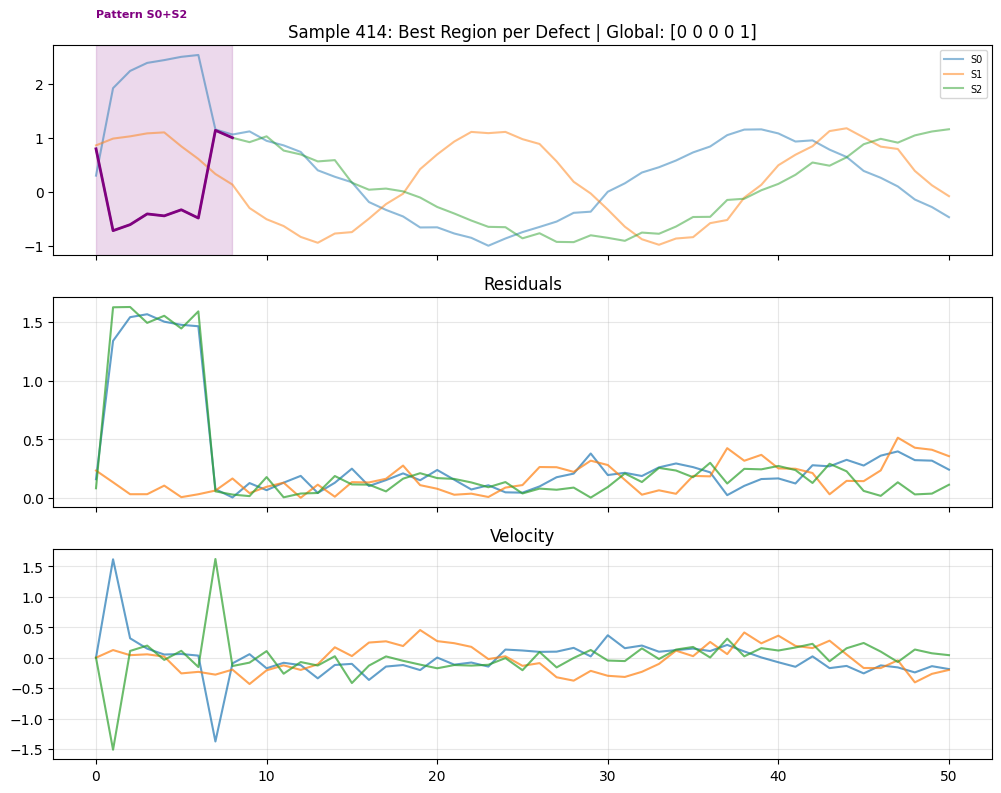

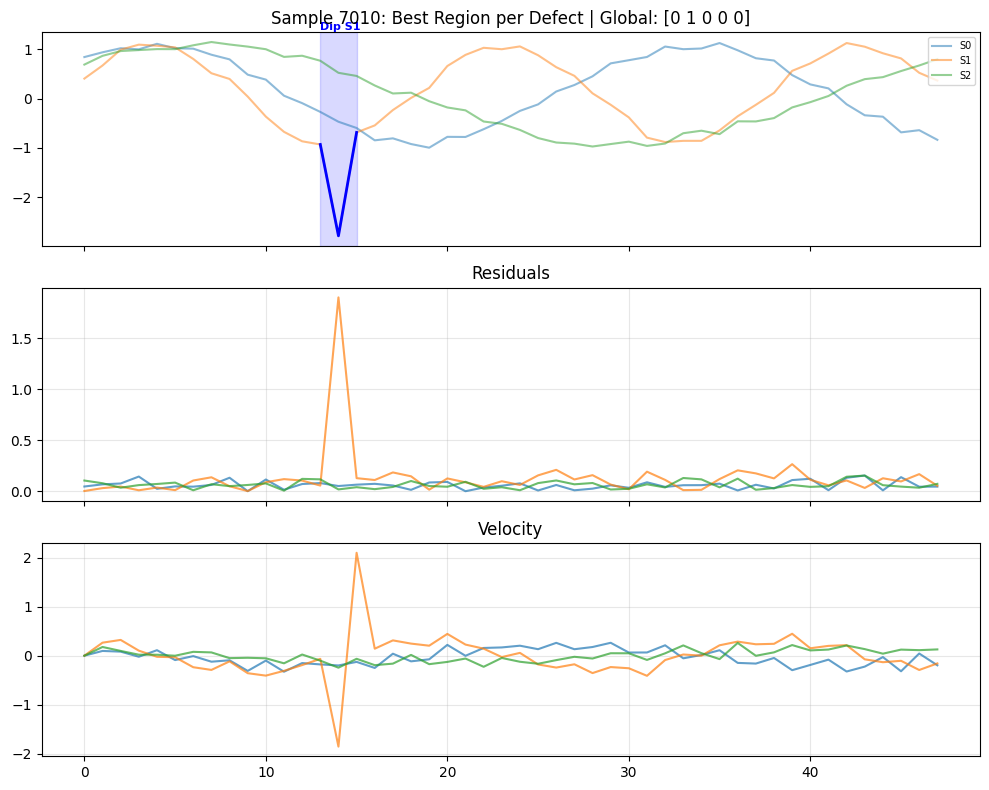

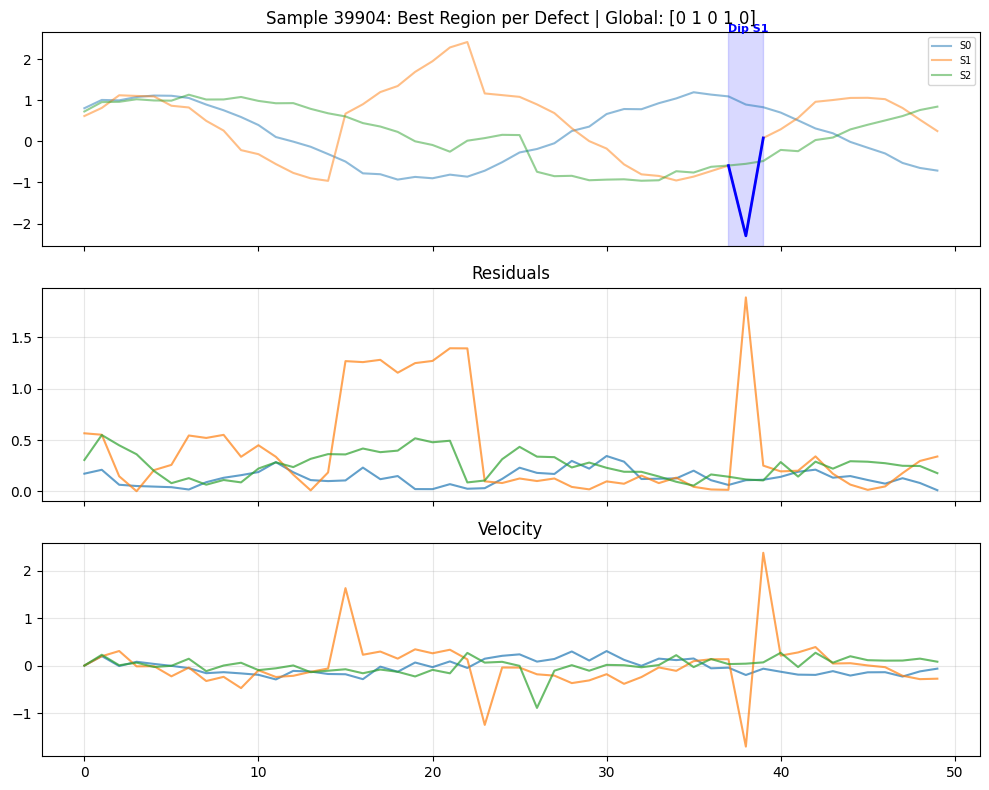

In [32]:
indices = np.random.choice(len(te_x), len(te_x), replace=False)
count = 0
max_display = 20

for idx in indices:
    if count >= max_display: break
    
    feat = te_x[idx]
    valid_len = (feat[:, 0] != PADDING_VALUE).sum().item()
    
    # 1. Global Inference (Consistency Check)
    inp = feat[:valid_len].unsqueeze(0).to(DEVICE)
    lens = torch.tensor([valid_len])
    with torch.no_grad():
        logits = model_clf(inp, lens)
        global_preds = (torch.sigmoid(logits).cpu().numpy()[0] > 0.5).astype(int)
    
    # Proceed only if defects exist globally
    if np.sum(global_preds) > 0:
        
        data_np = feat[:valid_len].numpy()
        orig = data_np[:, 0:3]
        resi = data_np[:, 3:6]
        velo = data_np[:, 6:9]
        
        # 2. Proposal (Local Stats)
        candidates = identify_candidates_per_sample(valid_len, resi, velo)
        
        potential_defects = [] 
        
        # 3. Verification
        for s, e in candidates:
            crop = feat[s:e+1]
            if len(crop) < 3: continue 
            
            c_inp = crop.unsqueeze(0).to(DEVICE)
            c_len = torch.tensor([len(crop)])
            
            with torch.no_grad():
                c_probs = torch.sigmoid(model_clf(c_inp, c_len)).cpu().numpy()[0]
            
            # Check local predictions
            local_preds = np.where(c_probs > 0.5)[0]
            
            for cls in local_preds:
                # CONSISTENCY CHECK: Global Veto
                if global_preds[cls] == 1:
                    potential_defects.append((s, e, cls, c_probs[cls]))
        
        # 4. Conflict Resolution
        confirmed = select_best_regions(potential_defects)
        
        if confirmed:
            count += 1
            
            # PLOT
            fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
            
            # Row 1: Original + Colored Regions
            ax[0].plot(orig, alpha=0.5)
            ax[0].set_title(f"Sample {idx}: Best Region per Defect | Global: {global_preds}")
            ax[0].legend(['S0', 'S1', 'S2'], loc='upper right', fontsize='x-small')
            
            for s, e, cls in confirmed:
                color = DEFECT_COLORS[cls]
                ax[0].axvspan(s, e, color=color, alpha=0.15)
                
                # Heuristic for bolding: Bold sensor with max residual in this region
                region_res = resi[s:e+1]
                max_res_sensor = np.argmax(np.max(region_res, axis=0))
                ax[0].plot(np.arange(s, e+1), orig[s:e+1, max_res_sensor], color=color, lw=2)
                
                ax[0].text(s, np.max(orig)+0.1 + (cls*0.15), DEFECT_NAMES[cls], 
                           color=color, fontsize=8, fontweight='bold')

            # Row 2: Residuals
            ax[1].plot(resi, alpha=0.7)
            ax[1].set_title("Residuals")
            ax[1].grid(alpha=0.3)
            
            # Row 3: Velocity
            ax[2].plot(velo, alpha=0.7)
            ax[2].set_title("Velocity")
            ax[2].grid(alpha=0.3)
            
            plt.tight_layout()
            plt.show()

This approach works really well if the defects are in different part of the timeseries. When they overlap, the performance of the explainability part decreases but is still suprisingly high taking into account the simplicity of the approach.